In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets

In [2]:
class NNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 100)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(100, 10)
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        return x

In [15]:
class Model:
    def __init__(self,n_epochs,Batchsize,learning_rate,Momentum=0.5,log_interval=10):
        self.network=NNetwork()
        self.n_epochs=n_epochs
        self.Batchsize=Batchsize
        self.orig_learning_rate=learning_rate
        self.learning_rate=learning_rate
        self.momentum=Momentum
        self.log_interval=log_interval
        self.epochs=[]
        self.train_losses = []
        self.train_acc=[]
        self.test_losses = []
        self.test_acc=[]
        
        apply_transform=transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: torch.flatten(x))])

        self.trainset=datasets.MNIST(root='./data',train=True,download=False,transform=apply_transform)
        self.train_loader=torch.utils.data.DataLoader(self.trainset,batch_size=self.Batchsize,shuffle=True)#create dataloader

        self.testset=datasets.MNIST(root='./data',train=False,download=True,transform=apply_transform)
        self.test_loader=torch.utils.data.DataLoader(self.testset,batch_size=self.Batchsize,shuffle=True)#create dataloader
    
    def speak(self):
        print("\n###########")
        print("LR: ",self.learning_rate)
        print("Batchsize: ",self.Batchsize)
        print("num_epochs: ",self.n_epochs)
        print(self.network)
        print("###########\n")
    
    def reset_learning_rate(self):
        self.learning_rate=self.orig_learning_rate
    
    def train(self,epoch):
        losses=[]
        self.network.train()
        optimizer = optim.SGD(self.network.parameters(), lr=self.learning_rate,
                          momentum=self.momentum)
        for batch_idx, (data, target) in enumerate(self.train_loader):
            optimizer.zero_grad()
            output = self.network(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
#             if batch_idx % 10 == 0:
#                 print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                     epoch, batch_idx * len(data), len(self.train_loader.dataset),
#                     100. * batch_idx / len(self.train_loader), loss.item()))
                #losses.append(loss.item())
                #train_counter.append(
                #(batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
                #torch.save(network.state_dict(), '/results/model.pth')
                #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
        print("\nSUMMARY FOR EPOCH:",epoch)
        print("Average train loss for epoch number -->",epoch,"is : ",sum(losses)/len(losses))
        self.train_losses.append(sum(losses)/len(losses))
        self.epochs.append(epoch)   
    
    def check(self,epoch):
        self.network.eval()
        test_loss = 0
        correct = 0

        with torch.no_grad():
            for data, target in self.train_loader:
                output = self.network(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        self.train_acc.append(100*correct.item()/len(self.train_loader.dataset))
        print("Training set accuracy:",100*correct.item()/len(self.train_loader.dataset))
        
        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                output = self.network(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss =test_loss/len(self.test_loader.dataset)
        self.test_losses.append(test_loss)
        print('Test set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            test_loss, correct, len(self.test_loader.dataset),
            100* correct.item() / len(self.test_loader.dataset)))
        print("Test set accuracy:",100*correct.item()/len(self.test_loader.dataset))
        self.test_acc.append(100*correct.item()/len(self.test_loader.dataset))
        
    def run_training(self,vary_learning_rate_with_epochs=False):
        if(vary_learning_rate_with_epochs==False):
            for i in range(1, self.n_epochs + 1):
                self.train(i)
                self.check(i)
            return
        else:
            print("learning_rate=",self.learning_rate)
            for i in range(1, self.n_epochs + 1):
                if(i%5==0):
                    self.learning_rate=self.learning_rate/2;
                    print("learning_rate halved at epoch: ",i,". New learning_rate =",self.learning_rate)
                self.train(i)
                self.check(i)
            return
    def finaltrainaccuracy(self):
        return self.train_acc[-1]
    
    def finaltestaccuracy(self):
        return self.test_acc[-1]
    
    def finaltrainerror(self):
        return self.train_losses[-1]
    
    def finaltesterror(self):
        return self.test_losses[-1] 

In [4]:
n_epochs=20
Batchsize=128
learning_rate=0.025

In [5]:
classifier=Model(n_epochs,Batchsize,learning_rate)
classifier.speak()

LR:  0.025
Batchsize:  128
num_epochs:  20
NNetwork(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)


In [6]:
classifier.run_training()


SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  -0.11104459352076435
Training set accuracy: 11.236666666666666


/home/nikhil/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: -0.1254, Accuracy: 1135/10000 (11%)
Test set accuracy: 11.35

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  -0.1542644320742916
Training set accuracy: 21.01
Test set: Avg. loss: -0.1909, Accuracy: 2107/10000 (21%)
Test set accuracy: 21.07

SUMMARY FOR EPOCH: 3
Average train loss for epoch number --> 3 is :  -0.2049656153392436
Training set accuracy: 21.035
Test set: Avg. loss: -0.2193, Accuracy: 2110/10000 (21%)
Test set accuracy: 21.1

SUMMARY FOR EPOCH: 4
Average train loss for epoch number --> 4 is :  -0.2313297615249528
Training set accuracy: 26.125
Test set: Avg. loss: -0.2481, Accuracy: 2676/10000 (27%)
Test set accuracy: 26.76

SUMMARY FOR EPOCH: 5
Average train loss for epoch number --> 5 is :  -0.2623411814795374
Training set accuracy: 33.931666666666665
Test set: Avg. loss: -0.2832, Accuracy: 3413/10000 (34%)
Test set accuracy: 34.13

SUMMARY FOR EPOCH: 6
Average train loss for epoch number --> 6 is :  -0.3032605444380978
Training s

# Question 4 #

## The loss used is negative log likelihood loss throughout and the same is used to denote error.

In [7]:
print("After",classifier.n_epochs," epochs of training with",classifier.learning_rate,"as learning rate and Batchsize=" ,classifier.Batchsize,":")
print("Training Accuracy: ",classifier.finaltrainaccuracy())
print("Testing Accuracy: ",classifier.finaltestaccuracy())
print("Training Loss: ",classifier.finaltrainerror())
print("Testing Loss: ",classifier.finaltesterror())

After 20  epochs of training with 0.025 as learning rate and Batchsize= 128 :
Training Accuracy:  71.18166666666667
Testing Accuracy:  70.87
Training Loss:  -0.6223573762216548
Testing Loss:  -0.6374501335144043


# Question 5

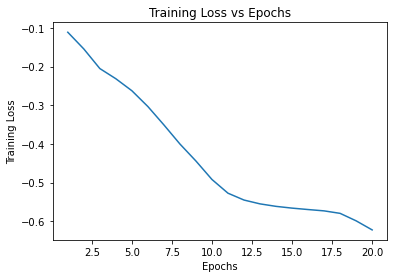

In [12]:
plt.plot(classifier.epochs,classifier.train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

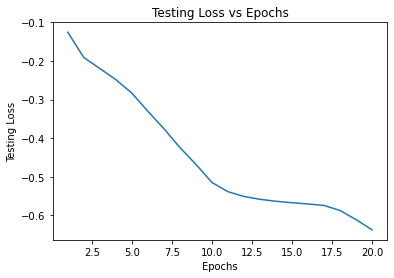

In [13]:
plt.plot(classifier.epochs,classifier.test_losses)
plt.xlabel("Epochs")
plt.ylabel("Testing Loss")
plt.title("Testing Loss vs Epochs")
plt.show()

# Question 6

## The following starts question 6 (a):

In [14]:
n_epochs=20
learning_rate=0.025
batchsizes=[32,64,128,256,512]
corresponding_final_train_error=[]
corresponding_final_test_error=[]
for i in range(len(batchsizes)):
    mod_obj=Model(n_epochs,batchsizes[i],learning_rate)
    mod_obj.speak()
    mod_obj.run_training()
    corresponding_final_train_error.append(mod_obj.finaltrainerror())
    corresponding_final_test_error.append(mod_obj.finaltesterror())

LR:  0.025
Batchsize:  32
num_epochs:  20
NNetwork(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  -0.17292998245358468
Training set accuracy: 24.95


/home/nikhil/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: -0.2423, Accuracy: 2457/10000 (25%)
Test set accuracy: 24.57

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  -0.3379449753642082
Training set accuracy: 48.90833333333333
Test set: Avg. loss: -0.4442, Accuracy: 4871/10000 (49%)
Test set accuracy: 48.71

SUMMARY FOR EPOCH: 3
Average train loss for epoch number --> 3 is :  -0.4680277198314667
Training set accuracy: 49.545
Test set: Avg. loss: -0.4783, Accuracy: 4933/10000 (49%)
Test set accuracy: 49.33

SUMMARY FOR EPOCH: 4
Average train loss for epoch number --> 4 is :  -0.5096372589508692
Training set accuracy: 63.75
Test set: Avg. loss: -0.5619, Accuracy: 6380/10000 (64%)
Test set accuracy: 63.8

SUMMARY FOR EPOCH: 5
Average train loss for epoch number --> 5 is :  -0.6035420822620392
Training set accuracy: 66.46333333333334
Test set: Avg. loss: -0.6274, Accuracy: 6633/10000 (66%)
Test set accuracy: 66.33

SUMMARY FOR EPOCH: 6
Average train loss for epoch number --> 6 is :  -0.6389554548422496



SUMMARY FOR EPOCH: 20
Average train loss for epoch number --> 20 is :  -0.6242017823495845
Training set accuracy: 65.365
Test set: Avg. loss: -0.6365, Accuracy: 6606/10000 (66%)
Test set accuracy: 66.06
LR:  0.025
Batchsize:  128
num_epochs:  20
NNetwork(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  -0.10526242968179524
Training set accuracy: 10.441666666666666
Test set: Avg. loss: -0.1126, Accuracy: 1028/10000 (10%)
Test set accuracy: 10.28

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  -0.13047968438947632
Training set accuracy: 20.411666666666665
Test set: Avg. loss: -0.1592, Accuracy: 2031/10000 (20%)
Test set accuracy: 20.31

SUMMARY FOR EPOCH: 3
Average train loss for epoch number --> 3 is :  -0.21334818628296923
Training set accuracy: 30.595
Test set: 


SUMMARY FOR EPOCH: 17
Average train loss for epoch number --> 17 is :  -0.4579069562414859
Training set accuracy: 49.251666666666665
Test set: Avg. loss: -0.4598, Accuracy: 4901/10000 (49%)
Test set accuracy: 49.01

SUMMARY FOR EPOCH: 18
Average train loss for epoch number --> 18 is :  -0.4643213712154551
Training set accuracy: 49.343333333333334
Test set: Avg. loss: -0.4649, Accuracy: 4913/10000 (49%)
Test set accuracy: 49.13

SUMMARY FOR EPOCH: 19
Average train loss for epoch number --> 19 is :  -0.46893128194707506
Training set accuracy: 49.43666666666667
Test set: Avg. loss: -0.4688, Accuracy: 4918/10000 (49%)
Test set accuracy: 49.18

SUMMARY FOR EPOCH: 20
Average train loss for epoch number --> 20 is :  -0.47296509996373604
Training set accuracy: 49.49333333333333
Test set: Avg. loss: -0.4721, Accuracy: 4930/10000 (49%)
Test set accuracy: 49.3
LR:  0.025
Batchsize:  512
num_epochs:  20
NNetwork(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(

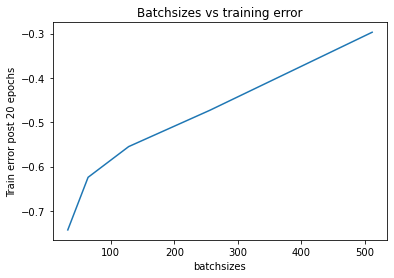

In [16]:
plt.plot(batchsizes,corresponding_final_train_error)
plt.xlabel("batchsizes")
plt.ylabel("Train error post 20 epochs")
plt.title("Batchsizes vs training error")
plt.show()

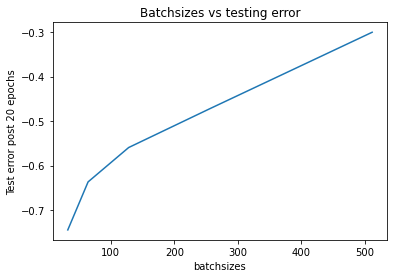

In [17]:
plt.plot(batchsizes,corresponding_final_test_error)
plt.xlabel("batchsizes")
plt.ylabel("Test error post 20 epochs")
plt.title("Batchsizes vs testing error")
plt.show()

## Question 6 (B):

In [18]:
n_epochs=20
learning_rates=[0.025,0.05,0.1,0.2,0.5]
batchsize=64
corresponding_final_train_error_vlr=[]
corresponding_final_test_error_vlr=[]
for i in range(len(learning_rates)):
    mod_obj=Model(n_epochs,batchsize,learning_rates[i])
    mod_obj.speak()
    mod_obj.run_training()
    corresponding_final_train_error_vlr.append(mod_obj.finaltrainerror())
    corresponding_final_test_error_vlr.append(mod_obj.finaltesterror())


###########
LR:  0.025
Batchsize:  64
num_epochs:  20
NNetwork(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
###########


SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  -0.11861860872840067
Training set accuracy: 20.923333333333332


/home/nikhil/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: -0.1712, Accuracy: 2105/10000 (21%)
Test set accuracy: 21.05

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  -0.21448027081231572
Training set accuracy: 28.826666666666668
Test set: Avg. loss: -0.2572, Accuracy: 2907/10000 (29%)
Test set accuracy: 29.07

SUMMARY FOR EPOCH: 3
Average train loss for epoch number --> 3 is :  -0.2927163044082076
Training set accuracy: 44.903333333333336
Test set: Avg. loss: -0.3468, Accuracy: 4545/10000 (45%)
Test set accuracy: 45.45

SUMMARY FOR EPOCH: 4
Average train loss for epoch number --> 4 is :  -0.40366929685319664
Training set accuracy: 48.86666666666667
Test set: Avg. loss: -0.4479, Accuracy: 4918/10000 (49%)
Test set accuracy: 49.18

SUMMARY FOR EPOCH: 5
Average train loss for epoch number --> 5 is :  -0.4581404044302796
Training set accuracy: 49.22833333333333
Test set: Avg. loss: -0.4713, Accuracy: 4956/10000 (50%)
Test set accuracy: 49.56

SUMMARY FOR EPOCH: 6
Average train loss for epoch number --> 

Training set accuracy: 76.90833333333333
Test set: Avg. loss: -0.7596, Accuracy: 7691/10000 (77%)
Test set accuracy: 76.91

SUMMARY FOR EPOCH: 20
Average train loss for epoch number --> 20 is :  -0.758823238138451
Training set accuracy: 76.955
Test set: Avg. loss: -0.7606, Accuracy: 7697/10000 (77%)
Test set accuracy: 76.97

###########
LR:  0.1
Batchsize:  64
num_epochs:  20
NNetwork(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
###########


SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  -0.2483176810464371
Training set accuracy: 48.288333333333334
Test set: Avg. loss: -0.4199, Accuracy: 4869/10000 (49%)
Test set accuracy: 48.69

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  -0.5184494476519159
Training set accuracy: 65.80666666666667
Test set: Avg. loss: -0.6169, Accuracy: 6589/10000 (66%)
Test set accur

Training set accuracy: 85.58166666666666
Test set: Avg. loss: -0.8397, Accuracy: 8467/10000 (85%)
Test set accuracy: 84.67

SUMMARY FOR EPOCH: 17
Average train loss for epoch number --> 17 is :  -0.8466646839687819
Training set accuracy: 85.735
Test set: Avg. loss: -0.8415, Accuracy: 8485/10000 (85%)
Test set accuracy: 84.85

SUMMARY FOR EPOCH: 18
Average train loss for epoch number --> 18 is :  -0.8487241966510887
Training set accuracy: 85.91666666666667
Test set: Avg. loss: -0.8432, Accuracy: 8496/10000 (85%)
Test set accuracy: 84.96

SUMMARY FOR EPOCH: 19
Average train loss for epoch number --> 19 is :  -0.8733656359379733
Training set accuracy: 93.15
Test set: Avg. loss: -0.9149, Accuracy: 9287/10000 (93%)
Test set accuracy: 92.87

SUMMARY FOR EPOCH: 20
Average train loss for epoch number --> 20 is :  -0.9237380069710298
Training set accuracy: 94.025
Test set: Avg. loss: -0.9281, Accuracy: 9401/10000 (94%)
Test set accuracy: 94.01

###########
LR:  0.5
Batchsize:  64
num_epochs:  2

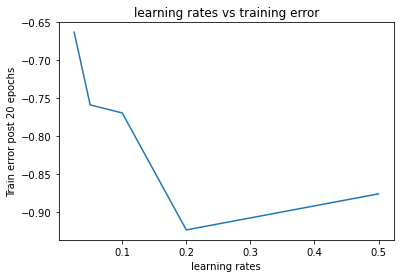

In [19]:
plt.plot(learning_rates,corresponding_final_train_error_vlr)
plt.xlabel("learning rates")
plt.ylabel("Train error post 20 epochs")
plt.title("learning rates vs training error")
plt.show()

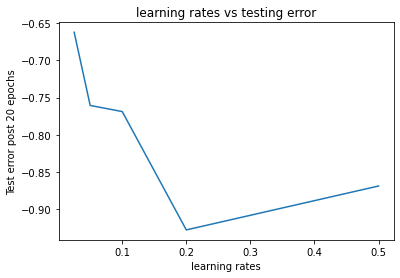

In [20]:
plt.plot(learning_rates,corresponding_final_test_error_vlr)
plt.xlabel("learning rates")
plt.ylabel("Test error post 20 epochs")
plt.title("learning rates vs testing error")
plt.show()

### According to the above graph, learning rate of around 0.2 converges the most quickly and hence we use some learning rate around it

## Question 6(c)

### The strategy that we use to decrease the learning rate here is that after every five epochs, we half the current learning rate. And thus we see the results. Starting learning rate would be 0.05. After 5 epochs it will update to 0.025, and so on. This can be done by passing the flag as True for varying learning rate when calling train of the object. It is implemented inside the running training. Please have a look above in the class Model.

In [22]:
n_epochs=20
learning_rate=0.05
batchsize=64
mod_obj=Model(n_epochs,batchsize,learning_rate)
mod_obj.speak()
mod_obj.run_training(vary_learning_rate_with_epochs=True)


###########
LR:  0.05
Batchsize:  64
num_epochs:  20
NNetwork(
  (hidden): Linear(in_features=784, out_features=100, bias=True)
  (output): Linear(in_features=100, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)
###########

learning_rate= 0.05

SUMMARY FOR EPOCH: 1
Average train loss for epoch number --> 1 is :  -0.16552593211915448
Training set accuracy: 22.213333333333335


/home/nikhil/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set: Avg. loss: -0.2407, Accuracy: 2258/10000 (23%)
Test set accuracy: 22.58

SUMMARY FOR EPOCH: 2
Average train loss for epoch number --> 2 is :  -0.3366378388806447
Training set accuracy: 57.44
Test set: Avg. loss: -0.4900, Accuracy: 5744/10000 (57%)
Test set accuracy: 57.44

SUMMARY FOR EPOCH: 3
Average train loss for epoch number --> 3 is :  -0.5363479527329077
Training set accuracy: 58.615
Test set: Avg. loss: -0.5580, Accuracy: 5854/10000 (59%)
Test set accuracy: 58.54

SUMMARY FOR EPOCH: 4
Average train loss for epoch number --> 4 is :  -0.5663336549105167
Training set accuracy: 58.958333333333336
Test set: Avg. loss: -0.5709, Accuracy: 5882/10000 (59%)
Test set accuracy: 58.82

SUMMARY FOR EPOCH: 5
Average train loss for epoch number --> 5 is :  -0.5757915709636359
Training set accuracy: 59.13333333333333
Test set: Avg. loss: -0.5774, Accuracy: 5891/10000 (59%)
Test set accuracy: 58.91

SUMMARY FOR EPOCH: 6
Average train loss for epoch number --> 6 is :  -0.601689069351153

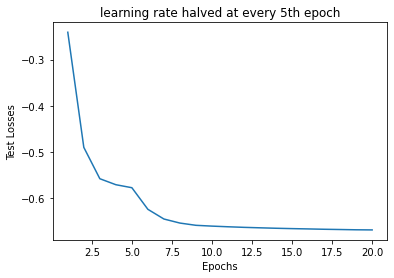

In [23]:
plt.plot(mod_obj.epochs,mod_obj.test_losses)
plt.xlabel("Epochs")
plt.ylabel("Test Losses")
plt.title("learning rate halved at every 5th epoch")
plt.show()

We observe that the curve becomes more gentle and converges more smoothly.